### 一.FFM原理介绍
FFM（Field-aware Factorization Machine）是对FM的改进，我们先回顾一下上一节的FM，它对于组合特征$x_ix_j$，设置的权重为$<v_i,v_j>$，而对于组合特征$x_ix_k$，设置的权重为$<x_i,x_k>$，可以发现这两项共享了同一个向量$v_i$，而FFM想法则是：   

（1）若特征$x_j$与$x_k$属性类似，即属于同一个field，则利用同一向量$v_i$；   

（2）若特征$x_j$与$x_k$属性不相似，即不属于同一个field，则使用不同的$v_i$；   

这样学习出来的向量会更有区分性，所以对于$v_i$我们需要对其扩展一个维度来表示field，比如对于$x_ix_j$组合特征，有$v_i\rightarrow v_{i,f_j}$，这里$f_j$即表示特征$j$所属的field，所以对于之前的FM模型方程，我们需要调整为：   

$$
y(x)=w_0+\sum_{i=1}^nw_ix_i+\sum_{i=1}^{n-1}\sum_{j=i+1}^n<v_{i,f_j},v_{j,f_i}>x_ix_j
$$  

这里，$n$表示特征数，如果隐向量维度为$k$，field数量为$f$，那么FFM的组合特征项的参数将会有$nfk$个，是FM模型参数$nk$的$f$倍，那么如何判断不同的特征是否属于同一个field呢，这一般看业务需求，通常同一个特征做one-hot展开后的特征组属于同一个field，下面通过例子来直观感受一下FMM模型特征组合方式，假设某条输入记录如下：   
![avatar](./source/17_FFM1.png)

这条记录可以编码成5个特征，其中“Genre=Comedy”和“Genre=Drama”属于同一个field，“Price”是数值型，不用One-Hot编码转换。为了方便说明FFM的样本格式，我们将所有的特征和对应的field映射成整数编号。
![avatar](./source/17_FFM2.png)
那么，FFM的组合特征有$(4*5)/2=10$项，如下图所示  
![avatar](./source/17_FFM3.png)  

需要注意的一点是同一个field之间的特征也可以构造组合特征（虽然one-hot展开后的特征没有组合的必要），接下来我们还需要推导一下梯度的求解，通过求解如下：  


$$
\frac{\partial}{\partial\theta}y(x)=\left\{\begin{matrix}
1 &\theta=w_0 \\ 
x_i &\theta=w_i \\ 
v_{j,f_i,l}x_ix_j & \theta=v_{i,f_j,l}
\end{matrix}\right.
$$  

这里，需要特别说明一下，对于$v$，采用逐特征组合的方式进行更新，故$1\leq i\leq j\leq n$，$1\leq l\leq k$表示隐含量维度，所以时间复杂度会比较高为$O(kn^2)$

### 二.代码实现
这一节还是先对回归任务做实现，损失函数还是采用平方损失，同上一节一样，可以得到梯度：   

$$
\frac{\partial L(\theta)}{\partial\theta}=(y(x)-t)\cdot\left\{\begin{matrix}
1 &\theta=w_0 \\ 
x_i &\theta=w_i \\ 
v_{j,f_i,l}x_ix_j & \theta=v_{i,f_j,l}
\end{matrix}\right.
$$   

另外对FFM补充一个功能，对于输入的特征，我们也许并不是都想要参与特征组合，这时可以将这部分特征的field id设置为负数，将其过滤掉，其余的field id取值0,1,2...即可

In [13]:
"""
FFM因子分解机的实现，代码封装到ml_models.fm中
"""
import numpy as np


class FFM(object):
    def __init__(self, epochs=1, lr=1e-3, adjust_lr=True, batch_size=1, hidden_dim=4, lamb=1e-3, alpha=1e-3,
                 normal=True, solver='adam', rho_1=0.9, rho_2=0.999, early_stopping_rounds=100):
        """

        :param epochs: 迭代轮数
        :param lr: 学习率
        :param adjust_lr:是否根据特征数量再次调整学习率 max(lr,1/n_feature)
        :param batch_size:
        :param hidden_dim:隐变量维度，也就是每个v_i的维数
        :param lamb:l2正则项系数
        :param alpha:l1正则项系数
        :param normal:是否归一化，默认用min-max归一化
        :param solver:优化方式，包括sgd,adam,默认adam
        :param rho_1:adam的rho_1的权重衰减,solver=adam时生效
        :param rho_2:adam的rho_2的权重衰减,solver=adam时生效
        :param early_stopping_rounds:对early_stopping进行支持，使用rmse作为评估指标，默认20
        """
        self.epochs = epochs
        self.lr = lr
        self.adjust_lr = adjust_lr
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.lamb = lamb
        self.alpha = alpha
        self.solver = solver
        self.rho_1 = rho_1
        self.rho_2 = rho_2
        self.early_stopping_rounds = early_stopping_rounds
        # 初始化参数
        self.w = None  # w_0,w_i
        self.V = None  # v_{i,f}
        # 归一化
        self.normal = normal
        if normal:
            self.xmin = None
            self.xmax = None
        # 功能性参数
        self.replace_ind = None  # 置换index
        self.positive_ind = None  # 参与特征组合的开始id
        self.fields = []  # replace_ind后的fields
        self.field_num = None

    def _y(self, X):
        """
        实现y(x)的功能
        :param X:
        :return:
        """
        # 去掉第一列bias以及非组合特征
        X_ = X[:, self.positive_ind + 1:]
        n_sample, n_feature = X_.shape
        pol = np.zeros(n_sample)
        for i in range(0, n_feature - 1):
            for j in range(i + 1, n_feature):
                pol += X_[:, i] * X_[:, j] * np.dot(self.V[i, self.fields[self.positive_ind + j]],
                                                    self.V[j, self.fields[self.positive_ind + i]])
        return X @ self.w.reshape(-1) + pol

    def fit(self, X, y, eval_set=None, show_log=False, fields=None):
        """
        :param X:
        :param y:
        :param eval_set:
        :param show_log:
        :param fields: 为None时，退化为FM
        :return:
        """
        X_o = X.copy()

        # 归一化
        if self.normal:
            self.xmin = X.min(axis=0)
            self.xmax = X.max(axis=0)
            X = (X - self.xmin) / self.xmax

        n_sample, n_feature = X.shape
        # 处理fields
        if fields is None:
            self.replace_ind = list(range(0, n_feature))
            self.positive_ind = 0
            self.fields = [0] * n_feature
            self.field_num = 1
        else:
            self.replace_ind = np.argsort(fields).tolist()
            # field小于零的数量，也即0field开始的索引
            self.positive_ind = np.sum([1 if item < 0 else 0 for item in fields])
            self.fields = sorted(fields)
            # 过滤掉负的field，计算所有的field数量
            self.field_num = len(set(self.fields[self.positive_ind:]))

        # reshape X
        X = X[:, self.replace_ind]

        x_y = np.c_[np.ones(n_sample), X, y]
        # 记录loss
        train_losses = []
        eval_losses = []
        # 调整一下学习率
        if self.adjust_lr:
            self.lr = max(self.lr, 1 / n_feature)
        # 初始化参数
        self.w = np.random.random((n_feature + 1, 1)) * 1e-3
        self.V = np.random.random((n_feature - self.positive_ind, self.field_num, self.hidden_dim)) * 1e-3
        if self.solver == 'adam':
            # 缓存梯度一阶，二阶估计
            w_1 = np.zeros_like(self.w)
            V_1 = np.zeros_like(self.V)
            w_2 = np.zeros_like(self.w)
            V_2 = np.zeros_like(self.V)
        # 更新参数
        count = 0
        for epoch in range(self.epochs):
            # 验证集记录
            best_eval_value = np.power(2., 1023)
            eval_count = 0
            np.random.shuffle(x_y)
            for index in range(x_y.shape[0] // self.batch_size):
                count += 1
                batch_x_y = x_y[self.batch_size * index : self.batch_size * (index + 1)]
                batch_x = batch_x_y[:, :-1]
                batch_y = batch_x_y[:, -1:]
                # 计算y(x)-t
                y_x_t = self._y(batch_x).reshape((-1, 1)) - batch_y
                
                # 更新w
                if self.solver == 'sgd':
                    self.w = self.w - (self.lr * (np.sum(y_x_t * batch_x, axis=0) / self.batch_size).reshape(
                        (-1, 1)) + self.lamb * self.w + self.alpha * np.where(self.w > 0, 1, 0))
                elif self.solver == 'adam':
                    w_reg = self.lamb * self.w + self.alpha * np.where(self.w > 0, 1, 0)
                    w_grad = (np.sum(y_x_t * batch_x, axis=0) / self.batch_size).reshape(
                        (-1, 1)) + w_reg
                    w_1 = self.rho_1 * w_1 + (1 - self.rho_1) * w_grad
                    w_2 = self.rho_2 * w_2 + (1 - self.rho_2) * w_grad * w_grad
                    w_1_ = w_1 / (1 - np.power(self.rho_1, count))
                    w_2_ = w_2 / (1 - np.power(self.rho_2, count))
                    self.w = self.w - (self.lr * w_1_) / (np.sqrt(w_2_) + 1e-8)

                # 更新 V
                # batch_x中有一列数据是1，所以需要去除前面的1+负的特征数量才是非负特征数量
                batch_x_ = batch_x[:, 1 + self.positive_ind:]
                # 逐元素更新
                for i in range(0, batch_x_.shape[1] - 1):
                    for j in range(i + 1, batch_x_.shape[1]):
                        for k in range(0, self.hidden_dim):
                            # 同时对两个参数V_i_fj_k和V_j_fi_k进行更新
                            v_reg_l = self.lamb * self.V[i, self.fields[self.positive_ind + j], k] + \
                                      self.alpha * (self.V[i, self.fields[self.positive_ind + j], k] > 0)

                            v_grad_l = np.sum(y_x_t.reshape(-1) * batch_x_[:, i] * batch_x_[:, j] *
                                              self.V[
                                                  j, self.fields[self.positive_ind + i], k]) / self.batch_size + v_reg_l

                            v_reg_r = self.lamb * self.V[j, self.fields[self.positive_ind + i], k] + \
                                      self.alpha * (self.V[j, self.fields[self.positive_ind + i], k] > 0)

                            v_grad_r = np.sum(y_x_t.reshape(-1) * batch_x_[:, i] * batch_x_[:, j] *
                                              self.V[
                                                  i, self.fields[self.positive_ind + j], k]) / self.batch_size + v_reg_r

                            if self.solver == "sgd":
                                self.V[i, self.fields[self.positive_ind + j], k] -= self.lr * v_grad_l
                                self.V[j, self.fields[self.positive_ind + i], k] -= self.lr * v_grad_r
                            elif self.solver == "adam":
                                V_1[i, self.fields[self.positive_ind + j], k] = self.rho_1 * V_1[
                                    i, self.fields[self.positive_ind + j], k] + (1 - self.rho_1) * v_grad_l
                                V_2[i, self.fields[self.positive_ind + j], k] = self.rho_2 * V_2[
                                    i, self.fields[self.positive_ind + j], k] + (1 - self.rho_2) * v_grad_l * v_grad_l
                                v_1_l = V_1[i, self.fields[self.positive_ind + j], k] / (
                                1 - np.power(self.rho_1, count))
                                v_2_l = V_2[i, self.fields[self.positive_ind + j], k] / (
                                1 - np.power(self.rho_2, count))

                                V_1[j, self.fields[self.positive_ind + i], k] = self.rho_1 * V_1[
                                    j, self.fields[self.positive_ind + i], k] + (1 - self.rho_1) * v_grad_r
                                V_2[j, self.fields[self.positive_ind + i], k] = self.rho_2 * V_2[
                                    j, self.fields[self.positive_ind + i], k] + (1 - self.rho_2) * v_grad_r * v_grad_r
                                v_1_r = V_1[j, self.fields[self.positive_ind + i], k] / (
                                1 - np.power(self.rho_1, count))
                                v_2_r = V_2[j, self.fields[self.positive_ind + i], k] / (
                                1 - np.power(self.rho_2, count))

                                self.V[i, self.fields[self.positive_ind + j], k] -= (self.lr * v_1_l) / (np.sqrt(v_2_l) + 1e-8)

                                self.V[j, self.fields[self.positive_ind + i], k] -= (self.lr * v_1_r) / (np.sqrt(v_2_r) + 1e-8)

                # 计算eval loss
                eval_loss = None
                if eval_set is not None:
                    eval_x, eval_y = eval_set
                    eval_loss = np.std(eval_y - self.predict(eval_x))
                    eval_losses.append(eval_loss)
                # 是否显示
                if show_log:
                    train_loss = np.std(y - self.predict(X_o))
                    print("epoch:", epoch + 1, "/", self.epochs, ",samples:", (index + 1) * self.batch_size, "/",
                          n_sample,
                          ",train loss:",
                          train_loss, ",eval loss:", eval_loss)
                    train_losses.append(train_loss)
                # 是否早停
                if eval_loss is not None and self.early_stopping_rounds is not None:
                    if eval_loss < best_eval_value:
                        eval_count = 0
                        best_eval_value = eval_loss
                    else:
                        eval_count += 1
                    if eval_count >= self.early_stopping_rounds:
                        print("---------------early_stopping-----------------------------")
                        break

        return train_losses, eval_losses

    def predict(self, X):
        """
        :param X:
        :return:
        """
        # 归一化
        if self.normal:
            X = (X - self.xmin) / self.xmax
        # reshape
        X = X[:, self.replace_ind]
        # 去掉非组合特征
        X_ = X[:, self.positive_ind:]
        n_sample, n_feature = X_.shape
        pol = np.zeros(n_sample)
        for i in range(0, n_feature - 1):
            for j in range(i + 1, n_feature):
                pol += X_[:, i] * X_[:, j] * np.dot(self.V[i, self.fields[self.positive_ind + j]],
                                                    self.V[j, self.fields[self.positive_ind + i]])
        return np.c_[np.ones(n_sample), X] @ self.w.reshape(-1) + pol

### 三.测试

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
#造伪数据
data1 = np.linspace(1, 10, num=100)
data2 = np.linspace(1, 10, num=100) + np.random.random(size=100)
data3 = np.linspace(10, 1, num=100)
target = data1 * 2 + data3 * 0.1 + data2 * 1 + 10 * data1 * data2 + np.random.random(size=100)
data = np.c_[data1, data2, data3]

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=0)

`fields`默认为None，这时FMM退化为FM，另外训练日志默认设置为了`show_log=False`

In [17]:
#训练模型
model = FFM(epochs=5)
train_losses,eval_losses = model.fit(X_train, y_train, eval_set=(X_test,y_test))

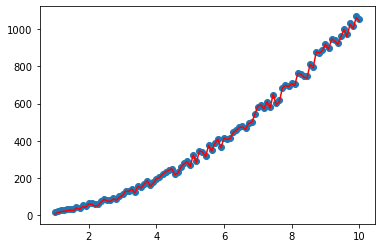

In [18]:
#查看拟合效果
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')

从造伪数据的过程，我们知道只有第一个和第二个特征有交叉，我们可以将第三个特征的field id设置为-1，使其不参与交叉

[[21.56617306]
 [28.81607753]
 [17.03736364]
 [17.05073078]]
[[[18.38387177 18.38382864 18.38291808 18.38365953]]

 [[18.38373907 18.38357329 18.38323598 18.38328719]]]


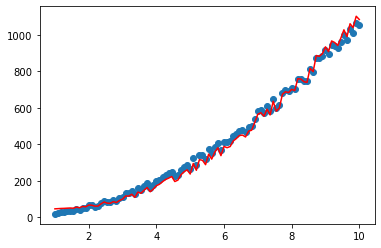

In [24]:
model = FFM(epochs=5)
train_losses,eval_losses = model.fit(X_train, y_train, eval_set=(X_test,y_test),fields=[0,0,-1])
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')
print(model.w)
print(model.V)

上面第一个特征和第二个特征的归为了同一个field（都为0），当然我们也可以将它们归为不同的field

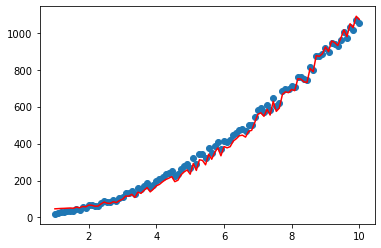

In [20]:
model = FFM(epochs=5)
train_losses,eval_losses = model.fit(X_train, y_train, eval_set=(X_test,y_test),fields=[0,1,-1])
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')

当然，我们也可以将每个特征设置为不同的field...

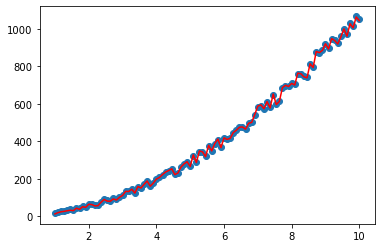

In [21]:
model = FFM(epochs=5)
train_losses,eval_losses = model.fit(X_train, y_train, eval_set=(X_test,y_test),fields=[0,1,2])
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')